# Warming trend and marine heat waves of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series for a Australian Marine Park, and to detect its warming trend and potential marine heat wave events.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
#from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

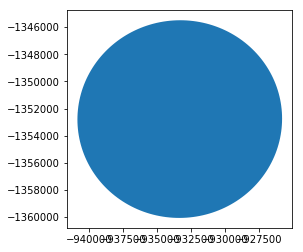

In [3]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


In [4]:
query = {'geopolygon': geom,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

**Load full time-series of SST (Sea Surface Temperature), for the Lord Howe Marine Park area, from 2002 to 2018. It tooks 5 hours. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [5]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:14:38.071516 to finish


In [6]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

**Mask the nodata (-999) as 'nan'**

In [7]:
data = mask_invalid_data(data)

In [8]:
# note the time dimension: 5900
data.dims


Frozen(SortedKeysDict({'time': 5900, 'y': 13, 'x': 12}))

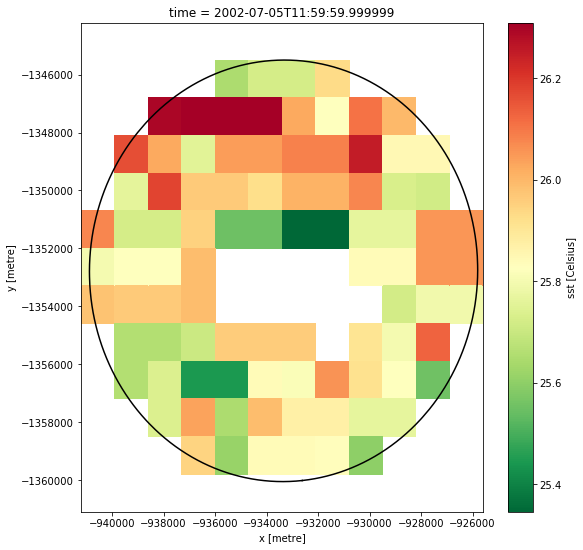

In [9]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(9,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.sst[1].plot(cmap='RdYlGn_r')

**testDF contains all SST data loaded: 3600 (90 x 40) locations (as columns) with 5900 daily time-series (as rows)**

In [10]:
testDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.y.size:
    while lonIndex < data.x.size:
        lat = data.sst[:,latIndex,lonIndex].y.values
        lon = data.sst[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        testDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
testDF['date'] = dateList
testDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

In [11]:
latlonDF.head(10)

,lat,lon
id,,
1,-1344850.0,-940550.0
2,-1344850.0,-939250.0
3,-1344850.0,-937950.0
4,-1344850.0,-936650.0
5,-1344850.0,-935350.0
6,-1344850.0,-934050.0
7,-1344850.0,-932750.0
8,-1344850.0,-931450.0
9,-1344850.0,-930150.0


In [120]:
testDF.head(10)

,1,2,3,4,5,6,7,8,9,10,...,147,148,149,150,151,152,153,154,155,156
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**The pad function interpolate over missing data in a time series. Courtesy of Hobday's marine heat waves codes**

In [13]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [14]:
testDF1 = testDF.drop(['20040229','20080229','20120229','20160229'])

**Calculate the dayofyear for each date, and add it to the DataFrame. 
Note that the removal of the Feb 29 dates results in the matching of the dayofyear across years**

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
i = 0
dayofyears = []

while i < testDF1.index.size:
    date = testDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    print(date)
    print(dayofyear)

    dayofyears.append(dayofyear)

    i = i + 1
testDF1['dayofyear']=dayofyears



20020704
185
20020705
186
20020706
187
20020707
188
20020708
189
20020709
190
20020710
191
20020711
192
20020712
193
20020713
194
20020714
195
20020715
196
20020716
197
20020717
198
20020718
199
20020719
200
20020720
201
20020721
202
20020722
203
20020723
204
20020724
205
20020725
206
20020726
207
20020727
208
20020728
209
20020729
210
20020807
219
20020808
220
20020809
221
20020810
222
20020811
223
20020812
224
20020813
225
20020814
226
20020815
227
20020816
228
20020817
229
20020818
230
20020819
231
20020820
232
20020821
233
20020822
234
20020823
235
20020824
236
20020825
237
20020826
238
20020827
239
20020828
240
20020829
241
20020830
242
20020831
243
20020901
244
20020902
245
20020903
246
20020904
247
20020905
248
20020906
249
20020907
250
20020908
251
20020909
252
20020910
253
20020911
254
20020912
255
20020913
256
20020914
257
20020915
258
20020916
259
20020917
260
20020918
261
20020919
262
20020920
263
20020921
264
20020922
265
20020923
266
20020924
267
20020925
268
20020926
269

14
20060115
15
20060116
16
20060117
17
20060118
18
20060119
19
20060120
20
20060121
21
20060122
22
20060123
23
20060124
24
20060125
25
20060126
26
20060127
27
20060128
28
20060129
29
20060130
30
20060131
31
20060201
32
20060202
33
20060203
34
20060204
35
20060205
36
20060206
37
20060207
38
20060208
39
20060209
40
20060210
41
20060211
42
20060212
43
20060213
44
20060214
45
20060215
46
20060216
47
20060217
48
20060218
49
20060219
50
20060220
51
20060221
52
20060222
53
20060223
54
20060224
55
20060225
56
20060226
57
20060227
58
20060228
59
20060301
60
20060302
61
20060303
62
20060304
63
20060305
64
20060306
65
20060307
66
20060308
67
20060309
68
20060310
69
20060311
70
20060312
71
20060313
72
20060314
73
20060315
74
20060316
75
20060317
76
20060318
77
20060319
78
20060320
79
20060321
80
20060322
81
20060323
82
20060324
83
20060325
84
20060326
85
20060327
86
20060328
87
20060329
88
20060330
89
20060331
90
20060401
91
20060402
92
20060403
93
20060404
94
20060405
95
20060406
96
20060407
97
2

321
20071118
322
20071119
323
20071120
324
20071121
325
20071122
326
20071123
327
20071124
328
20071125
329
20071126
330
20071127
331
20071128
332
20071129
333
20071130
334
20071201
335
20071203
337
20071204
338
20071205
339
20071206
340
20071207
341
20071208
342
20071209
343
20071210
344
20071211
345
20071212
346
20071213
347
20071214
348
20071215
349
20071216
350
20071217
351
20071218
352
20071219
353
20071220
354
20071221
355
20071222
356
20071223
357
20071224
358
20071225
359
20071226
360
20071227
361
20071228
362
20071229
363
20071230
364
20071231
365
20080101
1
20080102
2
20080103
3
20080104
4
20080105
5
20080106
6
20080107
7
20080108
8
20080109
9
20080110
10
20080111
11
20080112
12
20080113
13
20080114
14
20080115
15
20080116
16
20080117
17
20080118
18
20080119
19
20080120
20
20080121
21
20080122
22
20080123
23
20080124
24
20080125
25
20080126
26
20080127
27
20080128
28
20080129
29
20080130
30
20080131
31
20080201
32
20080202
33
20080203
34
20080204
35
20080205
36
20080206
37
20

83
20100325
84
20100326
85
20100327
86
20100328
87
20100329
88
20100330
89
20100331
90
20100401
91
20100402
92
20100403
93
20100404
94
20100405
95
20100406
96
20100407
97
20100408
98
20100409
99
20100410
100
20100411
101
20100412
102
20100413
103
20100414
104
20100415
105
20100416
106
20100417
107
20100418
108
20100419
109
20100420
110
20100421
111
20100422
112
20100423
113
20100424
114
20100425
115
20100426
116
20100427
117
20100428
118
20100429
119
20100430
120
20100501
121
20100502
122
20100503
123
20100504
124
20100505
125
20100506
126
20100507
127
20100508
128
20100509
129
20100510
130
20100511
131
20100512
132
20100513
133
20100514
134
20100515
135
20100516
136
20100517
137
20100518
138
20100519
139
20100520
140
20100521
141
20100522
142
20100523
143
20100524
144
20100525
145
20100526
146
20100527
147
20100528
148
20100529
149
20100530
150
20100531
151
20100601
152
20100602
153
20100603
154
20100604
155
20100605
156
20100606
157
20100607
158
20100608
159
20100609
160
20100610
161

323
20131120
324
20131121
325
20131122
326
20131123
327
20131124
328
20131125
329
20131126
330
20131127
331
20131128
332
20131129
333
20131130
334
20131201
335
20131202
336
20131203
337
20131204
338
20131205
339
20131206
340
20131207
341
20131208
342
20131209
343
20131210
344
20131211
345
20131212
346
20131213
347
20131214
348
20131215
349
20131216
350
20131217
351
20131218
352
20131219
353
20131220
354
20131221
355
20131222
356
20131223
357
20131224
358
20131225
359
20131226
360
20131227
361
20131228
362
20131229
363
20131230
364
20131231
365
20140101
1
20140102
2
20140103
3
20140104
4
20140105
5
20140106
6
20140107
7
20140108
8
20140109
9
20140110
10
20140111
11
20140112
12
20140113
13
20140114
14
20140115
15
20140116
16
20140117
17
20140118
18
20140119
19
20140120
20
20140121
21
20140122
22
20140123
23
20140124
24
20140125
25
20140126
26
20140127
27
20140128
28
20140129
29
20140130
30
20140131
31
20140201
32
20140202
33
20140203
34
20140204
35
20140205
36
20140206
37
20140207
38
201

20160403
93
20160404
94
20160405
95
20160406
96
20160407
97
20160408
98
20160409
99
20160410
100
20160411
101
20160412
102
20160413
103
20160414
104
20160415
105
20160416
106
20160417
107
20160418
108
20160419
109
20160420
110
20160421
111
20160422
112
20160423
113
20160424
114
20160425
115
20160426
116
20160427
117
20160428
118
20160429
119
20160430
120
20160501
121
20160502
122
20160503
123
20160504
124
20160505
125
20160506
126
20160507
127
20160508
128
20160509
129
20160510
130
20160511
131
20160512
132
20160513
133
20160514
134
20160515
135
20160516
136
20160517
137
20160518
138
20160519
139
20160520
140
20160521
141
20160522
142
20160523
143
20160524
144
20160525
145
20160526
146
20160527
147
20160528
148
20160529
149
20160530
150
20160531
151
20160601
152
20160602
153
20160603
154
20160604
155
20160605
156
20160606
157
20160607
158
20160608
159
20160609
160
20160610
161
20160611
162
20160612
163
20160613
164
20160614
165
20160615
166
20160616
167
20160617
168
20160618
169
201606

In [16]:
testDF1.shape

(5896, 157)

**The testIDF1 is generated from testDF1 after applying the interpolation (pad) function**

In [17]:
testIDF1 = pd.DataFrame()
interpolatedSSTList = []

for i in testDF1.columns:
    sst = testDF1[i].values
    if np.isnan(sst).all():
        print(i, 'no data')
        latlonDF = latlonDF.drop(i, axis=0)
    else:
        interpolatedSST = pad(sst,maxPadLength=2)
        testIDF1[i] = interpolatedSST
    
testIDF1['date'] = testDF1.index
testIDF1['dayofyear'] = testDF1['dayofyear'].values
testIDF1.set_index('date', inplace=True)

1 no data
2 no data
3 no data
4 no data
5 no data
6 no data
7 no data
8 no data
9 no data
10 no data
11 no data
12 no data
13 no data
14 no data
15 no data
16 no data
21 no data
22 no data
23 no data
24 no data
25 no data
26 no data
35 no data
36 no data
37 no data
48 no data
49 no data
60 no data
97 no data
108 no data
109 no data
120 no data
121 no data
122 no data
131 no data
132 no data
133 no data
134 no data
135 no data
142 no data
143 no data
144 no data
145 no data
146 no data
147 no data
148 no data
149 no data
150 no data
151 no data
152 no data
153 no data
154 no data
155 no data
156 no data


In [18]:
testIDF1.shape

(5896, 103)

In [19]:
x = testIDF1.loc['20020704']
# counting the number of nan in x
np.count_nonzero(np.isnan(x))

2

**The 90 percentile is used as the threshold to identify the MHWs.
The SST values of the same dayofyear are grouped. The 90 percentile is then calculated for each group**

In [20]:
# 90th percentile from testIDF1
nintyDF = pd.DataFrame()

i = 1
while i < 3601:
    print(str(i))
    sst_series_g = testIDF1[i].groupby(testIDF1['dayofyear'])
    sst_90 = sst_series_g.transform(nintypercentile)
    nintyDF[i] = sst_90
    i += 1
nintyDF['date'] = testDF1.index
nintyDF['dayofyear'] = testDF1['dayofyear'].values
nintyDF.set_index('date', inplace=True)

1


KeyError: 1

**Another way of calculating the 90 perentile threshold. This time uses a 11-days window so that 
we have a much larger number of SST values each date from which to calculate the 90 percentile.
This also smoothes the 90 percentile climatology to a large degree.**

In [353]:
# 90th percentile with 11-days window
# this one takes too long to complete
nintyDF1 = pd.DataFrame()
i = 1

while i < 3601:
    print(str(i))
    nintyList = []
    for date in testIDF1.index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF1[i] = nintyList
    i += 1
nintyDF1['date'] = testDF1.index
nintyDF1['dayofyear'] = testDF1['dayofyear'].values
nintyDF1.set_index('date', inplace=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


**More efficient codes to calculate the 90 percentile climatology data with 11-days window are shown 
in the next few cells**

In [21]:
# 90th percentile with 11-days window
# this one takes much shorter to complete, as it only runs for one year cycle
nintyDF2 = pd.DataFrame()

print('start', datetime.now())
for i in testIDF1.columns:
    print(str(i))
    nintyList = []
    dayofyearList = []
    for date in testIDF1.loc['20030101':'20031231'].index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)o
    nintyDF2[i] = nintyList
   
#nintyDF2['date'] = testDF1.index
nintyDF2['dayofyear'] = dayofyearList
nintyDF2.set_index('dayofyear', inplace=True)
print('end', datetime.now())

start 2019-05-29 08:30:04.391896
17
18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
dayofyear
end 2019-05-29 08:31:34.217972


In [22]:
nintyDF3 = testIDF1.copy(deep=True)

In [23]:
print('start', datetime.now())
for date in nintyDF3.index:
    print(date)
    dayofyear = nintyDF3.dayofyear.loc[date]
    print(dayofyear)
    for doy in nintyDF2.index:
        if dayofyear == doy:
            nintyDF3.loc[date] = nintyDF2.loc[doy]
            nintyDF3.dayofyear.loc[date] = str(dayofyear)
    
print('end', datetime.now())

start 2019-05-29 08:32:15.568465
20020704
185
20020705
186.0


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


20020706
187.0
20020707
188.0
20020708
189.0
20020709
190.0
20020710
191.0
20020711
192.0
20020712
193.0
20020713
194.0
20020714
195.0
20020715
196.0
20020716
197.0
20020717
198.0
20020718
199.0
20020719
200.0
20020720
201.0
20020721
202.0
20020722
203.0
20020723
204.0
20020724
205.0
20020725
206.0
20020726
207.0
20020727
208.0
20020728
209.0
20020729
210.0
20020807
219.0
20020808
220.0
20020809
221.0
20020810
222.0
20020811
223.0
20020812
224.0
20020813
225.0
20020814
226.0
20020815
227.0
20020816
228.0
20020817
229.0
20020818
230.0
20020819
231.0
20020820
232.0
20020821
233.0
20020822
234.0
20020823
235.0
20020824
236.0
20020825
237.0
20020826
238.0
20020827
239.0
20020828
240.0
20020829
241.0
20020830
242.0
20020831
243.0
20020901
244.0
20020902
245.0
20020903
246.0
20020904
247.0
20020905
248.0
20020906
249.0
20020907
250.0
20020908
251.0
20020909
252.0
20020910
253.0
20020911
254.0
20020912
255.0
20020913
256.0
20020914
257.0
20020915
258.0
20020916
259.0
20020917
260.0
20020918
2

20040122
22.0
20040123
23.0
20040124
24.0
20040125
25.0
20040126
26.0
20040127
27.0
20040128
28.0
20040129
29.0
20040130
30.0
20040131
31.0
20040201
32.0
20040202
33.0
20040203
34.0
20040204
35.0
20040205
36.0
20040206
37.0
20040207
38.0
20040208
39.0
20040209
40.0
20040210
41.0
20040211
42.0
20040212
43.0
20040213
44.0
20040214
45.0
20040215
46.0
20040216
47.0
20040217
48.0
20040218
49.0
20040219
50.0
20040220
51.0
20040221
52.0
20040222
53.0
20040223
54.0
20040224
55.0
20040225
56.0
20040226
57.0
20040227
58.0
20040228
59.0
20040301
60.0
20040302
61.0
20040303
62.0
20040304
63.0
20040305
64.0
20040306
65.0
20040307
66.0
20040308
67.0
20040309
68.0
20040310
69.0
20040311
70.0
20040312
71.0
20040313
72.0
20040314
73.0
20040315
74.0
20040316
75.0
20040317
76.0
20040318
77.0
20040319
78.0
20040320
79.0
20040321
80.0
20040322
81.0
20040323
82.0
20040324
83.0
20040325
84.0
20040326
85.0
20040327
86.0
20040328
87.0
20040329
88.0
20040330
89.0
20040331
90.0
20040401
91.0
20040402
92.0
200404

20050806
218.0
20050807
219.0
20050808
220.0
20050809
221.0
20050810
222.0
20050811
223.0
20050812
224.0
20050813
225.0
20050814
226.0
20050815
227.0
20050816
228.0
20050817
229.0
20050818
230.0
20050819
231.0
20050820
232.0
20050821
233.0
20050822
234.0
20050823
235.0
20050824
236.0
20050825
237.0
20050826
238.0
20050827
239.0
20050828
240.0
20050829
241.0
20050830
242.0
20050831
243.0
20050901
244.0
20050902
245.0
20050903
246.0
20050904
247.0
20050905
248.0
20050906
249.0
20050907
250.0
20050908
251.0
20050909
252.0
20050910
253.0
20050911
254.0
20050912
255.0
20050913
256.0
20050914
257.0
20050915
258.0
20050916
259.0
20050917
260.0
20050918
261.0
20050919
262.0
20050920
263.0
20050921
264.0
20050922
265.0
20050923
266.0
20050924
267.0
20050925
268.0
20050926
269.0
20050927
270.0
20050928
271.0
20050929
272.0
20050930
273.0
20051001
274.0
20051002
275.0
20051003
276.0
20051004
277.0
20051005
278.0
20051006
279.0
20051007
280.0
20051008
281.0
20051009
282.0
20051010
283.0
20051011
2

20070215
46.0
20070216
47.0
20070217
48.0
20070218
49.0
20070219
50.0
20070220
51.0
20070221
52.0
20070222
53.0
20070223
54.0
20070224
55.0
20070225
56.0
20070226
57.0
20070227
58.0
20070228
59.0
20070301
60.0
20070302
61.0
20070303
62.0
20070304
63.0
20070305
64.0
20070306
65.0
20070307
66.0
20070308
67.0
20070309
68.0
20070310
69.0
20070311
70.0
20070312
71.0
20070313
72.0
20070314
73.0
20070315
74.0
20070316
75.0
20070317
76.0
20070318
77.0
20070319
78.0
20070320
79.0
20070321
80.0
20070322
81.0
20070323
82.0
20070324
83.0
20070325
84.0
20070326
85.0
20070327
86.0
20070328
87.0
20070329
88.0
20070330
89.0
20070331
90.0
20070401
91.0
20070402
92.0
20070403
93.0
20070404
94.0
20070405
95.0
20070406
96.0
20070407
97.0
20070408
98.0
20070409
99.0
20070410
100.0
20070411
101.0
20070412
102.0
20070413
103.0
20070414
104.0
20070415
105.0
20070416
106.0
20070417
107.0
20070418
108.0
20070419
109.0
20070420
110.0
20070421
111.0
20070422
112.0
20070423
113.0
20070424
114.0
20070425
115.0
2007

20080830
242.0
20080831
243.0
20080901
244.0
20080902
245.0
20080903
246.0
20080904
247.0
20080905
248.0
20080906
249.0
20080907
250.0
20080908
251.0
20080909
252.0
20080910
253.0
20080911
254.0
20080912
255.0
20080913
256.0
20080914
257.0
20080915
258.0
20080916
259.0
20080917
260.0
20080918
261.0
20080919
262.0
20080920
263.0
20080921
264.0
20080922
265.0
20080923
266.0
20080924
267.0
20080925
268.0
20080926
269.0
20080927
270.0
20080928
271.0
20080929
272.0
20080930
273.0
20081001
274.0
20081002
275.0
20081003
276.0
20081004
277.0
20081005
278.0
20081006
279.0
20081007
280.0
20081008
281.0
20081009
282.0
20081010
283.0
20081011
284.0
20081012
285.0
20081013
286.0
20081014
287.0
20081015
288.0
20081016
289.0
20081017
290.0
20081018
291.0
20081019
292.0
20081020
293.0
20081021
294.0
20081022
295.0
20081023
296.0
20081024
297.0
20081025
298.0
20081026
299.0
20081027
300.0
20081028
301.0
20081029
302.0
20081030
303.0
20081031
304.0
20081101
305.0
20081102
306.0
20081103
307.0
20081104
3

20100315
74.0
20100316
75.0
20100317
76.0
20100318
77.0
20100319
78.0
20100320
79.0
20100321
80.0
20100322
81.0
20100323
82.0
20100324
83.0
20100325
84.0
20100326
85.0
20100327
86.0
20100328
87.0
20100329
88.0
20100330
89.0
20100331
90.0
20100401
91.0
20100402
92.0
20100403
93.0
20100404
94.0
20100405
95.0
20100406
96.0
20100407
97.0
20100408
98.0
20100409
99.0
20100410
100.0
20100411
101.0
20100412
102.0
20100413
103.0
20100414
104.0
20100415
105.0
20100416
106.0
20100417
107.0
20100418
108.0
20100419
109.0
20100420
110.0
20100421
111.0
20100422
112.0
20100423
113.0
20100424
114.0
20100425
115.0
20100426
116.0
20100427
117.0
20100428
118.0
20100429
119.0
20100430
120.0
20100501
121.0
20100502
122.0
20100503
123.0
20100504
124.0
20100505
125.0
20100506
126.0
20100507
127.0
20100508
128.0
20100509
129.0
20100510
130.0
20100511
131.0
20100512
132.0
20100513
133.0
20100514
134.0
20100515
135.0
20100516
136.0
20100517
137.0
20100518
138.0
20100519
139.0
20100520
140.0
20100521
141.0
201005

20110924
267.0
20110925
268.0
20110926
269.0
20110927
270.0
20110928
271.0
20110929
272.0
20110930
273.0
20111001
274.0
20111002
275.0
20111003
276.0
20111004
277.0
20111005
278.0
20111006
279.0
20111007
280.0
20111008
281.0
20111009
282.0
20111010
283.0
20111011
284.0
20111012
285.0
20111013
286.0
20111014
287.0
20111015
288.0
20111016
289.0
20111017
290.0
20111018
291.0
20111019
292.0
20111020
293.0
20111021
294.0
20111022
295.0
20111023
296.0
20111024
297.0
20111025
298.0
20111026
299.0
20111027
300.0
20111028
301.0
20111029
302.0
20111030
303.0
20111031
304.0
20111101
305.0
20111102
306.0
20111103
307.0
20111104
308.0
20111105
309.0
20111106
310.0
20111107
311.0
20111108
312.0
20111109
313.0
20111110
314.0
20111111
315.0
20111112
316.0
20111113
317.0
20111114
318.0
20111115
319.0
20111116
320.0
20111117
321.0
20111118
322.0
20111119
323.0
20111120
324.0
20111121
325.0
20111122
326.0
20111123
327.0
20111124
328.0
20111125
329.0
20111126
330.0
20111127
331.0
20111128
332.0
20111129
3

20130409
99.0
20130410
100.0
20130411
101.0
20130412
102.0
20130413
103.0
20130414
104.0
20130415
105.0
20130416
106.0
20130417
107.0
20130418
108.0
20130419
109.0
20130420
110.0
20130421
111.0
20130422
112.0
20130423
113.0
20130424
114.0
20130425
115.0
20130426
116.0
20130427
117.0
20130428
118.0
20130429
119.0
20130430
120.0
20130501
121.0
20130502
122.0
20130503
123.0
20130504
124.0
20130505
125.0
20130506
126.0
20130507
127.0
20130508
128.0
20130509
129.0
20130510
130.0
20130511
131.0
20130512
132.0
20130513
133.0
20130514
134.0
20130515
135.0
20130516
136.0
20130517
137.0
20130518
138.0
20130519
139.0
20130520
140.0
20130521
141.0
20130522
142.0
20130523
143.0
20130524
144.0
20130525
145.0
20130526
146.0
20130527
147.0
20130528
148.0
20130529
149.0
20130530
150.0
20130531
151.0
20130601
152.0
20130602
153.0
20130603
154.0
20130604
155.0
20130605
156.0
20130606
157.0
20130607
158.0
20130608
159.0
20130609
160.0
20130610
161.0
20130611
162.0
20130612
163.0
20130613
164.0
20130614
16

20141017
290.0
20141018
291.0
20141019
292.0
20141020
293.0
20141021
294.0
20141022
295.0
20141023
296.0
20141024
297.0
20141025
298.0
20141026
299.0
20141027
300.0
20141028
301.0
20141029
302.0
20141030
303.0
20141031
304.0
20141101
305.0
20141102
306.0
20141103
307.0
20141104
308.0
20141105
309.0
20141106
310.0
20141107
311.0
20141108
312.0
20141109
313.0
20141110
314.0
20141111
315.0
20141112
316.0
20141113
317.0
20141114
318.0
20141115
319.0
20141116
320.0
20141117
321.0
20141118
322.0
20141119
323.0
20141120
324.0
20141121
325.0
20141122
326.0
20141123
327.0
20141124
328.0
20141125
329.0
20141126
330.0
20141127
331.0
20141128
332.0
20141129
333.0
20141130
334.0
20141201
335.0
20141202
336.0
20141203
337.0
20141204
338.0
20141205
339.0
20141206
340.0
20141207
341.0
20141208
342.0
20141209
343.0
20141210
344.0
20141211
345.0
20141212
346.0
20141213
347.0
20141214
348.0
20141215
349.0
20141216
350.0
20141217
351.0
20141218
352.0
20141219
353.0
20141220
354.0
20141221
355.0
20141222
3

20160502
122.0
20160503
123.0
20160504
124.0
20160505
125.0
20160506
126.0
20160507
127.0
20160508
128.0
20160509
129.0
20160510
130.0
20160511
131.0
20160512
132.0
20160513
133.0
20160514
134.0
20160515
135.0
20160516
136.0
20160517
137.0
20160518
138.0
20160519
139.0
20160520
140.0
20160521
141.0
20160522
142.0
20160523
143.0
20160524
144.0
20160525
145.0
20160526
146.0
20160527
147.0
20160528
148.0
20160529
149.0
20160530
150.0
20160531
151.0
20160601
152.0
20160602
153.0
20160603
154.0
20160604
155.0
20160605
156.0
20160606
157.0
20160607
158.0
20160608
159.0
20160609
160.0
20160610
161.0
20160611
162.0
20160612
163.0
20160613
164.0
20160614
165.0
20160615
166.0
20160616
167.0
20160617
168.0
20160618
169.0
20160619
170.0
20160620
171.0
20160621
172.0
20160622
173.0
20160623
174.0
20160624
175.0
20160625
176.0
20160626
177.0
20160627
178.0
20160628
179.0
20160629
180.0
20160630
181.0
20160701
182.0
20160702
183.0
20160703
184.0
20160704
185.0
20160705
186.0
20160706
187.0
20160707
1

20171108
312.0
20171109
313.0
20171110
314.0
20171111
315.0
20171112
316.0
20171113
317.0
20171114
318.0
20171115
319.0
20171116
320.0
20171117
321.0
20171118
322.0
20171119
323.0
20171120
324.0
20171121
325.0
20171122
326.0
20171123
327.0
20171124
328.0
20171125
329.0
20171126
330.0
20171127
331.0
20171128
332.0
20171129
333.0
20171130
334.0
20171201
335.0
20171202
336.0
20171203
337.0
20171204
338.0
20171205
339.0
20171206
340.0
20171207
341.0
20171208
342.0
20171209
343.0
20171210
344.0
20171211
345.0
20171212
346.0
20171213
347.0
20171214
348.0
20171215
349.0
20171216
350.0
20171217
351.0
20171218
352.0
20171219
353.0
20171220
354.0
20171221
355.0
20171222
356.0
20171223
357.0
20171224
358.0
20171225
359.0
20171226
360.0
20171227
361.0
20171228
362.0
20171229
363.0
20171230
364.0
20171231
365.0
20180201
32.0
20180202
33.0
20180203
34.0
20180204
35.0
20180205
36.0
20180206
37.0
20180207
38.0
20180208
39.0
20180209
40.0
20180210
41.0
20180211
42.0
20180212
43.0
20180213
44.0
20180214

**We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

In [24]:
nintyDF4 = nintyDF3.copy(deep=True)

In [25]:
nintyDF4 = nintyDF4.rolling(31,center=True).mean()

In [26]:
nintyDF4['dayofyear'] = nintyDF3.dayofyear

**Calculate the SST anomalies (differences) between the SST values and the 90 percentile data**

In [27]:
print('start', datetime.now())
diffDF4 = pd.DataFrame()


for i in testIDF1.columns:
    if i == 'dayofyear':
        print(i)
    else:
        
        diff = testIDF1[i] - nintyDF4[i]
        diffDF4[i] = diff
   
diffDF4['date'] = testDF1.index
diffDF4.set_index('date', inplace=True)
print('end', datetime.now())

start 2019-05-29 08:43:43.122849
dayofyear
end 2019-05-29 08:43:43.439172


In [28]:
testIDF1.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,26.920000,27.030001,26.940001,26.945000,26.930000,26.825001,26.825001,26.825001,26.940001,26.844999,...,26.700001,26.830000,26.830000,27.145000,27.145000,26.700001,26.700001,26.705000,26.705000,185
20020705,25.650000,25.725000,25.725000,25.930000,26.295000,26.309999,26.309999,26.309999,26.025000,25.825001,...,25.875000,25.764999,25.764999,25.945000,25.615000,25.840000,25.840000,25.834999,25.600000,186
20020706,26.825001,26.570000,26.764999,26.620001,26.915001,26.795000,26.795000,26.885000,26.690001,26.780001,...,26.520000,26.639999,26.645000,26.580000,26.580000,26.465000,26.379999,26.520000,26.504999,187
20020707,26.540001,26.465000,26.512501,26.420000,26.602501,26.685001,26.564999,26.627501,26.597500,26.600000,...,26.492500,26.485001,26.442501,26.330000,26.452499,26.462500,26.320000,26.447500,26.337500,188
20020708,26.254999,26.360001,26.260000,26.219999,26.290001,26.575001,26.334999,26.370001,26.504999,26.420000,...,26.465000,26.330000,26.240000,26.080000,26.325001,26.459999,26.260000,26.375000,26.170000,189
20020709,26.250000,26.302502,26.307499,26.240000,26.232500,26.375000,26.459999,26.435001,26.439999,26.415001,...,26.545000,26.337500,26.389999,26.244999,26.367500,26.439999,26.285000,26.244999,26.227501,190
20020710,26.245001,26.245001,26.355000,26.260000,26.174999,26.174999,26.584999,26.500000,26.375000,26.410000,...,26.625000,26.344999,26.540001,26.410000,26.410000,26.420000,26.309999,26.115000,26.285000,191
20020711,26.340000,26.035000,26.355000,26.410000,26.365000,26.400000,26.180000,26.355000,26.355000,26.410000,...,26.445000,26.219999,26.424999,26.280001,26.280001,26.485001,26.565001,26.445000,26.379999,192
20020712,26.110001,26.299999,26.275000,26.299999,26.330000,25.940001,25.940001,26.379999,26.379999,26.299999,...,26.125000,26.155001,26.155001,25.940001,26.230000,26.365000,26.420000,26.254999,26.440001,193


In [29]:
nintyDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.0
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.0
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.0
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.0


In [30]:
diffDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**plot the two 90 percentile dataset together. One is from 11-days window; the other illustrates further 
smooth using 31-days running average.**

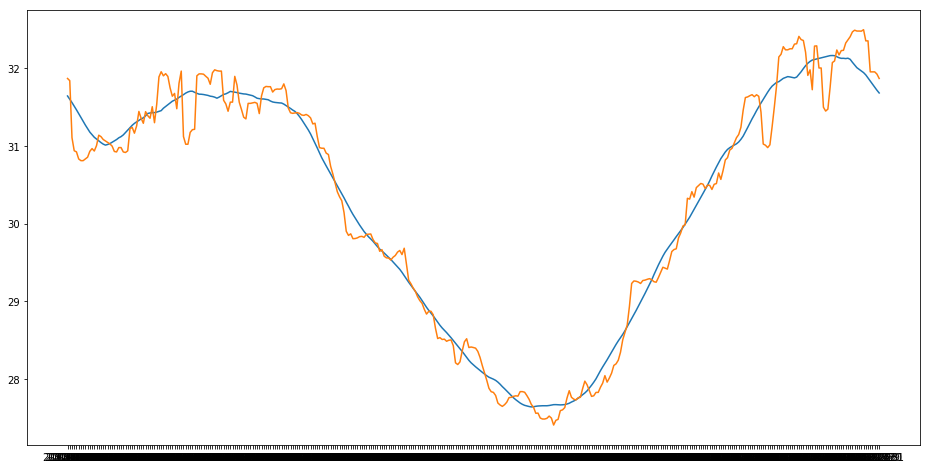

In [31]:
fig = plt.figure(figsize=(16,8))
plt.plot(nintyDF4.loc['20120101':'20121231'][17])
plt.plot(nintyDF3.loc['20120101':'20121231'][17])

**The main function to identify the MHW events and generate statistics. Return two dataframes. 
One contains the summary statistics. The other contains the intensity of the MHW days, so that we can 
generate daily spatial statistics. The function also saves individual MHW files and the summary statistics file.** 

In [32]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd
from datetime import datetime

def do_analysis(sstDiff_data,lonlatDF,amp,outDir):
    
    print(datetime.now())
   
    
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    #mhwEList = []
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    


   
    # loop through each Point
    for id in sstDiff_data.columns:
        print(str(id))
        idList.append(id)
        # create a dataframe to store characteristics of the MHWs events identified for this point
        mhwE = pd.DataFrame()
        date_start = []
        date_end = []
        duration = []

        # get the point values as a numpy array, the empty value is NaN
        point1 = sstDiff_data[id]
        point1V = point1.values
        dates = sstDiff_data.index.values

        # replace the NaN values with '-9999'
        point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
        # convert negative values into 0 and positive values into 1
        point1V_1[point1V_1<=0] = False
        point1V_1[point1V_1>0] = True
        # label events: positive value(s)
       
        events, n_events = label(point1V_1)
        #print(events)
        #print(n_events)
        for ev in range(1,n_events+1):
            # calculate duration of an event
            event_duration = (events == ev).sum()
            # initially identify all events with duration of 4+ days
            # isolated 4-day event(s) will be eventually removed
            if event_duration > 3:

                date_start.append(dates[np.where(events == ev)[0][0]])
                date_end.append(dates[np.where(events == ev)[0][-1]])
                duration.append(event_duration)
        # the initial list of mhwE
        mhwE['date_start'] = date_start
        mhwE['date_end'] = date_end
        mhwE['duration'] = duration

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:

            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if gap < 3:
                # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            elif gap < 4:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            mhwE['duration'][i] = duration
            i = i + 1

        # calculate mhw properties: intensity max, intensity mean, intensity std, 
        # cumulative intensity, onset rate and decline rate
        intensity_max = []
        intensity_mean = []
        intensity_std = []
        intensity_cumulative = []

        onset_rate = []
        decline_rate = []
        i = 0
      
        while i < mhwE.index.size:
            intensity_values = []
            date_values = []
            startDate = mhwE.iloc[i]['date_start']
            endDate = mhwE.iloc[i]['date_end']
            duration = mhwE.iloc[i]['duration']

            j = 0
            while j < sstDiff_data.index.size:

                date1 = dates[j]
                if startDate == date1:
                    k = j + int(duration)

                    while j < k:

                        sst_diff = point1V[j]
                        intensity_values.append(sst_diff)
                        dateV = dates[j]
                        date_values.append(dateV)
                        j = j + 1
                else:
                    j = j + 1
            #print('event', i, ':', intensity_values)
            np_intensity = np.array(intensity_values)
            np_date = np.array(date_values)

            startDiff = np_intensity[0]
            endDiff = np_intensity[-1]
            maxDiff = np_intensity.max()
            meanDiff = np_intensity.mean()
            stdDiff = np_intensity.std()
            cumDiff = np_intensity.sum()
      
            peakDate = np_date[np_intensity == maxDiff][0]

            dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                        datetime.strptime(str(startDate),'%Y%m%d')).days
            if dateDiff1 > 0:        
                rateOnset = (maxDiff - startDiff) / dateDiff1
            else: # the start date is the peak date
                rateOnset = maxDiff / 0.5

            dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                        datetime.strptime(str(peakDate),'%Y%m%d')).days
            if dateDiff2 > 0:        
                rateDecline = (maxDiff - endDiff) / dateDiff2
            else: # the end date is the peak date
                rateDecline = maxDiff / 0.5


            intensity_max.append(maxDiff)
            intensity_mean.append(meanDiff)
            intensity_std.append(stdDiff)
            intensity_cumulative.append(cumDiff)

            onset_rate.append(rateOnset)
            decline_rate.append(rateDecline)
            i = i + 1

        mhwE['maxIntensity'] = intensity_max
        mhwE['meanIntensity'] = intensity_mean
        mhwE['stdIntensity'] = intensity_std
        mhwE['cumIntensity'] = intensity_cumulative

        mhwE['onsetRate'] = onset_rate
        mhwE['declineRate'] = decline_rate

        # save the MHWs events identified for the point into a CSV file
        filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
        mhwE.to_csv(filename, sep=',', index=False)
        
        
        # generate a statsDF to extract the intensity for the days identified as part of a MHW
        if mhwE.index.size > 0:
            statsDF[str(id)] = np.nan
            for j in mhwE.index:    
                date_start = str(int(mhwE.loc[j]['date_start']))
                date_end = str(int(mhwE.loc[j]['date_end']))
                statsDF.loc[date_start:date_end,str(id)] = sstDiff_data.loc[date_start:date_end][id].values
         

    #   geneate the summary characteristics of the MHWs    
    #    mhwEList.append(mhwE)
        if mhwE.index.size > 0:

            noEvents.append(mhwE.index.size)
            noDays.append(mhwE['duration'].sum())
            totalIntensity.append(mhwE['cumIntensity'].sum())
            overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())

            tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
            HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
            HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
            highestIntensity.append(mhwE['maxIntensity'].max())
            date_start_HI.append(HIDate)
            duration_HI.append(HIDuration)

            tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
            LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
            largestDuration.append(mhwE['duration'].max())
            date_start_LD.append(LDDate)
            intensityLD.append(intensityLDV)


            tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
            LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
            largestMeanIntensity.append(mhwE['meanIntensity'].max())
            date_start_LMI.append(LMIDate)
            duration_LMI.append(LMIDuration)    


            tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
            LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
            largestCumIntensity.append(mhwE['cumIntensity'].max())
            date_start_LCI.append(LCIDate)
            duration_LCI.append(LCIDuration)
        else:
            noEvents.append(0)
            noDays.append(0)
            totalIntensity.append(0)
            overallIntensity.append(0)

            highestIntensity.append(0)
            date_start_HI.append(0)
            duration_HI.append(0)


            largestDuration.append(0)
            date_start_LD.append(0)
            intensityLD.append(0)


            largestMeanIntensity.append(0)
            date_start_LMI.append(0)
            duration_LMI.append(0)

            largestCumIntensity.append(0)
            date_start_LCI.append(0)
            duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    mhwDF1['lat'] = latlonDF.lat.values
    mhwDF1['lon'] = latlonDF.lon.values
    #mhwDF1['MHWs'] = mhwEList
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    print(datetime.now())
    return mhwDF1, statsDF


**Apply the main function**

In [46]:
outdir = '/home/547/zxh547/dea-notebooks/CI'
amp = 'CI'
mhwDF4, statsDF4 = do_analysis(diffDF4,latlonDF,amp,outdir)

2019-05-29 09:08:05.326818
17


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
2019-05-29 09:09:40.609102


In [34]:
mhwDF4.shape

(102, 19)

In [35]:
mhwDF4.tail(10)

,pointID,lat,lon,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI
92,127,-1357850.0,-932750.0,8,60,40.629456,0.677158,2.333840,540,16,16,540,1.053979,1.053979,540,16,16.863669,540,16
93,128,-1357850.0,-931450.0,11,90,52.336880,0.581521,2.356157,540,17,17,540,1.128905,1.128905,540,17,19.191389,540,17
94,129,-1357850.0,-930150.0,8,71,45.770338,0.644653,1.588218,543,14,18,509,0.724216,1.014710,543,14,14.205937,543,14
95,130,-1357850.0,-928850.0,9,73,45.819700,0.627667,1.615145,509,18,18,509,0.649182,1.023566,-692,5,12.229553,543,14
96,136,-1359150.0,-936650.0,10,76,46.192374,0.607794,2.326621,538,8,11,665,0.386127,0.925616,517,10,9.256164,517,10
97,137,-1359150.0,-935350.0,8,74,49.028376,0.662546,2.280420,539,18,18,509,0.714810,1.076927,539,18,19.384684,539,18
98,138,-1359150.0,-934050.0,12,93,56.987321,0.612767,2.427828,-1985,5,18,509,0.652344,1.121126,-1985,5,13.083958,540,16
99,139,-1359150.0,-932750.0,10,82,48.774291,0.594808,2.201446,541,15,15,512,0.725900,0.867517,541,15,13.012754,541,15
100,140,-1359150.0,-931450.0,8,62,35.500949,0.572596,1.629022,546,11,16,511,0.718992,0.958576,546,11,11.503874,511,16
101,141,-1359150.0,-930150.0,9,60,35.997356,0.599956,1.769063,546,11,11,546,0.967407,0.967407,546,11,10.641480,546,11


In [47]:
statsDF4.shape

(5896, 100)

In [48]:
statsDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
x = statsDF4.loc['20061202']
print(np.count_nonzero(~np.isnan(x)))
x = testIDF1.loc['20061202']
# counting the number of not nan in x
print(np.count_nonzero(~np.isnan(x)))

0
26


**Calculate summary statistics for the second dataframe**

In [50]:
minList = []
maxList = []
meanList = []
stdList = []
countList = []
observedList = []
for i in statsDF4.index:
    minList.append(statsDF4.loc[i].min())
    maxList.append(statsDF4.loc[i].max())
    meanList.append(statsDF4.loc[i].mean())
    stdList.append(statsDF4.loc[i].std())
    countList.append(statsDF4.loc[i].count())
    x = testIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(x))
    observedList.append(observed)
statsDF4['min'] = minList
statsDF4['max'] = maxList
statsDF4['mean'] = meanList
statsDF4['std'] = stdList
statsDF4['count'] = countList
statsDF4['observed'] = observedList

    

In [51]:
print(statsDF4.shape)
print(testIDF1.shape)


(5896, 106)
(5896, 103)


In [52]:
statsDF4.head(50)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,101
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,102


In [53]:
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20160601':'20160831',col1:col2].values
y=statsDF4.loc['20160601':'20160831','count'].values
print(x[x>=0].size)
z = statsDF4.loc['20160601':'20160831','observed'].values
k = z[y>0]
print(y.sum())
print(k.sum())

17 141
3271
3271
5826


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


**Generate seasonal statistics**

In [54]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = []
observed1List = []
observed2List = []
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20020704':'20020831',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20020704':'20020831','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20020704':'20020831','count'].values
k = y[z>0]
observed1List.append(k.sum())

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    i += 1

x=statsDF4.loc['20180901':'20181012',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20180901':'20181012','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20180901':'20181012','count'].values
k = y[z>0]
observed1List.append(k.sum())

seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList
seasonDF4['observed1'] = observed1List
seasonDF4['observed2'] = observed2List


17 141
20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
201

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3

In [65]:
seasonDF4.index

Index(['2002 winter', '2002 spring', '2002-03 summer', '2003 autumn',
       '2003 winter', '2003 spring', '2003-04 summer', '2004 autumn',
       '2004 winter', '2004 spring', '2004-05 summer', '2005 autumn',
       '2005 winter', '2005 spring', '2005-06 summer', '2006 autumn',
       '2006 winter', '2006 spring', '2006-07 summer', '2007 autumn',
       '2007 winter', '2007 spring', '2007-08 summer', '2008 autumn',
       '2008 winter', '2008 spring', '2008-09 summer', '2009 autumn',
       '2009 winter', '2009 spring', '2009-10 summer', '2010 autumn',
       '2010 winter', '2010 spring', '2010-11 summer', '2011 autumn',
       '2011 winter', '2011 spring', '2011-12 summer', '2012 autumn',
       '2012 winter', '2012 spring', '2012-13 summer', '2013 autumn',
       '2013 winter', '2013 spring', '2013-14 summer', '2014 autumn',
       '2014 winter', '2014 spring', '2014-15 summer', '2015 autumn',
       '2015 winter', '2015 spring', '2015-16 summer', '2016 autumn',
       '2016 winter'

In [109]:
import os
import pandas as pd
import numpy as np
statsDF1 = pd.DataFrame()
statsDF1['date'] = testIDF1.index
statsDF1.set_index('date', inplace=True)
statsDF2 = pd.DataFrame()
statsDF2['date'] = testIDF1.index
statsDF2.set_index('date', inplace=True)
print(statsDF1.index.size)
indir = '/home/547/zxh547/dea-notebooks/CI'
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if (f.endswith('.csv')) & (f.find('mhw') ==0):
            id = f.split('_')[1].split('.')[0]
            mhwDF = pd.read_csv(indir+'/'+f, sep=',', header=0)
            if mhwDF.index.size > 0:
                statsDF1[id] = np.nan
                for i in mhwDF.index:
                    meanIntensity = mhwDF.loc[i]['meanIntensity']
                    date_start = str(int(mhwDF.loc[i]['date_start']))
                    date_end = str(int(mhwDF.loc[i]['date_end']))
                    statsDF1.loc[date_start:date_end,id] = meanIntensity

countList = []
observedList = []
for i in statsDF1.index:
    x = statsDF1.loc[i]
    count = x[x>=0].size
    countList.append(count)
    y = testIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(y))
    observedList.append(observed)

statsDF2['count'] = countList
statsDF2['observed'] = observedList

5896


In [110]:
statsDF2.loc['20160501','count':'observed']

count        13
observed    103
Name: 20160501, dtype: int64

In [96]:
statsDF4.loc['20160501','count':'observed']

count        13.0
observed    103.0
Name: 20160501, dtype: float64

In [111]:
statsDF2.head(10)

,count,observed
date,,
20020704,0,101
20020705,0,98
20020706,0,98
20020707,0,97
20020708,0,97
20020709,0,97
20020710,0,100
20020711,0,100
20020712,0,102


In [112]:
statsDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,101
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,100
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,102


In [117]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring']
seasonDF2 = pd.DataFrame()
seasonDF2['season'] = seasonList
seasonDF2.set_index('season',inplace=True)
countList = []
observed1List = []
observed2List = []
mhwDaysList = []
noDaysList = []

x=statsDF2.loc['20020704':'20020831','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20020704':'20020831','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF2.loc[date1:date2,'count'].values
    count = x.sum()
    countList.append(count)
    y=statsDF2.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    k = y[x>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(x.size)
    i += 1

x=statsDF2.loc['20180901':'20181012','count'].values
count = x.sum()
countList.append(count)
y=statsDF2.loc['20180901':'20181012','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
k = y[x>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(x.size)

seasonDF2['count'] = countList
seasonDF2['observed1'] = observed1List
seasonDF2['observed2'] = observed2List
seasonDF2['mhwDays'] = mhwDaysList
seasonDF2['noDays'] = noDaysList


20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
20160601 2

In [121]:
seasonDF2.head(40)

,count,observed1,observed2,mhwDays,noDays
season,,,,,
2002 winter,0,0,4903,0,51
2002 spring,0,0,3937,0,91
2002-03 summer,0,0,1121,0,90
2003 autumn,0,0,6533,0,92
2003 winter,0,0,8112,0,92
2003 spring,0,0,5676,0,91
2003-04 summer,0,0,1525,0,90
2004 autumn,0,0,5865,0,92
2004 winter,0,0,6623,0,92


In [122]:
seasonDF2.to_csv('/home/547/zxh547/dea-notebooks/CI/seasonDF2.csv', sep=',', index=True)

In [116]:
seasonDF4.head(40)

,min,max,mean,std,sum,count,observed1,observed2
season,,,,,,,,
2002 winter,NaN,NaN,NaN,NaN,NaN,0,0,4903
2002 spring,NaN,NaN,NaN,NaN,NaN,0,0,3937
2002-03 summer,NaN,NaN,NaN,NaN,NaN,0,0,1121
2003 autumn,NaN,NaN,NaN,NaN,NaN,0,0,6533
2003 winter,NaN,NaN,NaN,NaN,NaN,0,0,8112
2003 spring,NaN,NaN,NaN,NaN,NaN,0,0,5676
2003-04 summer,NaN,NaN,NaN,NaN,NaN,0,0,1525
2004 autumn,NaN,NaN,NaN,NaN,NaN,0,0,5865
2004 winter,NaN,NaN,NaN,NaN,NaN,0,0,6623


**Plot a figure usign the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW days for each season. The colors indicates other statistics, for example the maximum MHW intensity 
in this case.**

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  self.axes.set_ylim((ymin, ymax), auto=None)


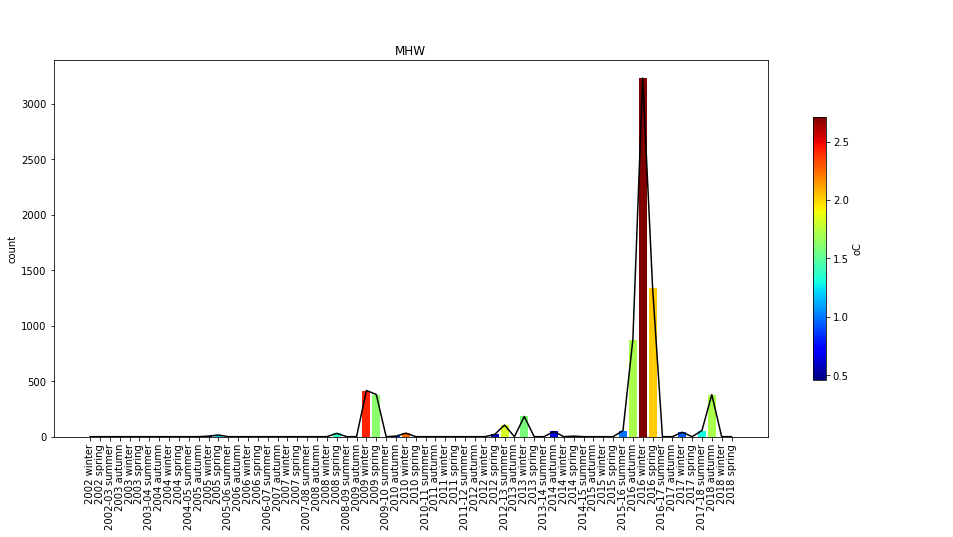

In [41]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
y = seasonDF4['count'].values
z1 = seasonDF4['max'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**Add the summary statistics into the 'data' as addiontal variables, so that we can display them 
as maps**

In [54]:
mhwDF4.set_index('pointID',inplace=True)

In [57]:
latSize = data.latitude.size
lonSize = data.longitude.size
noEventsA = mhwDF4['noEvents'].values.reshape(latSize,lonSize)
noDaysA = mhwDF4['noDays'].values.reshape(latSize,lonSize)
totalIntensityA = mhwDF4['totalIntensity'].values.reshape(latSize,lonSize)
overallIntensityA = mhwDF4['overallIntensity'].values.reshape(latSize,lonSize)
highestIntensityA = mhwDF4['highestIntensity'].values.reshape(latSize,lonSize)
date_start_HIA = mhwDF4['date_start_HI'].values.reshape(latSize,lonSize)
largestDurationA = mhwDF4['largestDuration'].values.reshape(latSize,lonSize)
date_start_LDA = mhwDF4['date_start_LD'].values.reshape(latSize,lonSize)
intensityLDA = mhwDF4['intensityLD'].values.reshape(latSize,lonSize)
largestMeanIntensityA = mhwDF4['largestMeanIntensity'].values.reshape(latSize,lonSize)
date_start_LMIA = mhwDF4['date_start_LMI'].values.reshape(latSize,lonSize)
duration_LMIA = mhwDF4['duration_LMI'].values.reshape(latSize,lonSize)
largestCumIntensityA = mhwDF4['largestCumIntensity'].values.reshape(latSize,lonSize)
date_start_LCIA = mhwDF4['date_start_LCI'].values.reshape(latSize,lonSize)
duration_LCIA = mhwDF4['duration_LCI'].values.reshape(latSize,lonSize)


In [58]:
data['noEvents'] = (('latitude','longitude'), noEventsA)
data['noDays'] = (('latitude','longitude'), noDaysA)
data['totalIntensity'] = (('latitude','longitude'), totalIntensityA)
data['overallIntensity'] = (('latitude','longitude'), overallIntensityA)
data['highestIntensity'] = (('latitude','longitude'), highestIntensityA)
data['date_start_HI'] = (('latitude','longitude'), date_start_HIA)
data['largestDuration'] = (('latitude','longitude'), largestDurationA)
data['date_start_LD'] = (('latitude','longitude'), date_start_LDA)
data['intensityLD'] = (('latitude','longitude'), intensityLDA)
data['largestMeanIntensity'] = (('latitude','longitude'), largestMeanIntensityA)
data['date_start_LMI'] = (('latitude','longitude'), date_start_LMIA)
data['duration_LMI'] = (('latitude','longitude'), duration_LMIA)
data['largestCumIntensity'] = (('latitude','longitude'), largestCumIntensityA)
data['date_start_LCI'] = (('latitude','longitude'), date_start_LCIA)
data['duration_LCI'] = (('latitude','longitude'), duration_LCIA)

In [59]:
data

<xarray.Dataset>
Dimensions:               (latitude: 64, longitude: 17, time: 5900)
Coordinates:
  * time                  (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-12T11:59:59.999999
  * latitude              (latitude) float64 -28.85 -28.95 ... -35.05 -35.15
  * longitude             (longitude) float64 158.3 158.4 158.5 ... 159.8 159.9
Data variables:
    sst                   (time, latitude, longitude) float32 nan nan ... 15.565
    noEvents              (latitude, longitude) int64 9 14 11 10 11 ... 7 5 5 6
    noDays                (latitude, longitude) int64 65 86 63 65 ... 37 32 34
    totalIntensity        (latitude, longitude) float64 28.02 43.13 ... 26.8
    overallIntensity      (latitude, longitude) float64 0.4311 0.5015 ... 0.7882
    highestIntensity      (latitude, longitude) float64 2.766 2.978 ... 1.924
    date_start_HI         (latitude, longitude) int64 -3910 -1404 ... 1134 1302
    largestDuration       (latitude, longitude) int64 11 9 7 15 16 

**Display the summary statistics as maps**

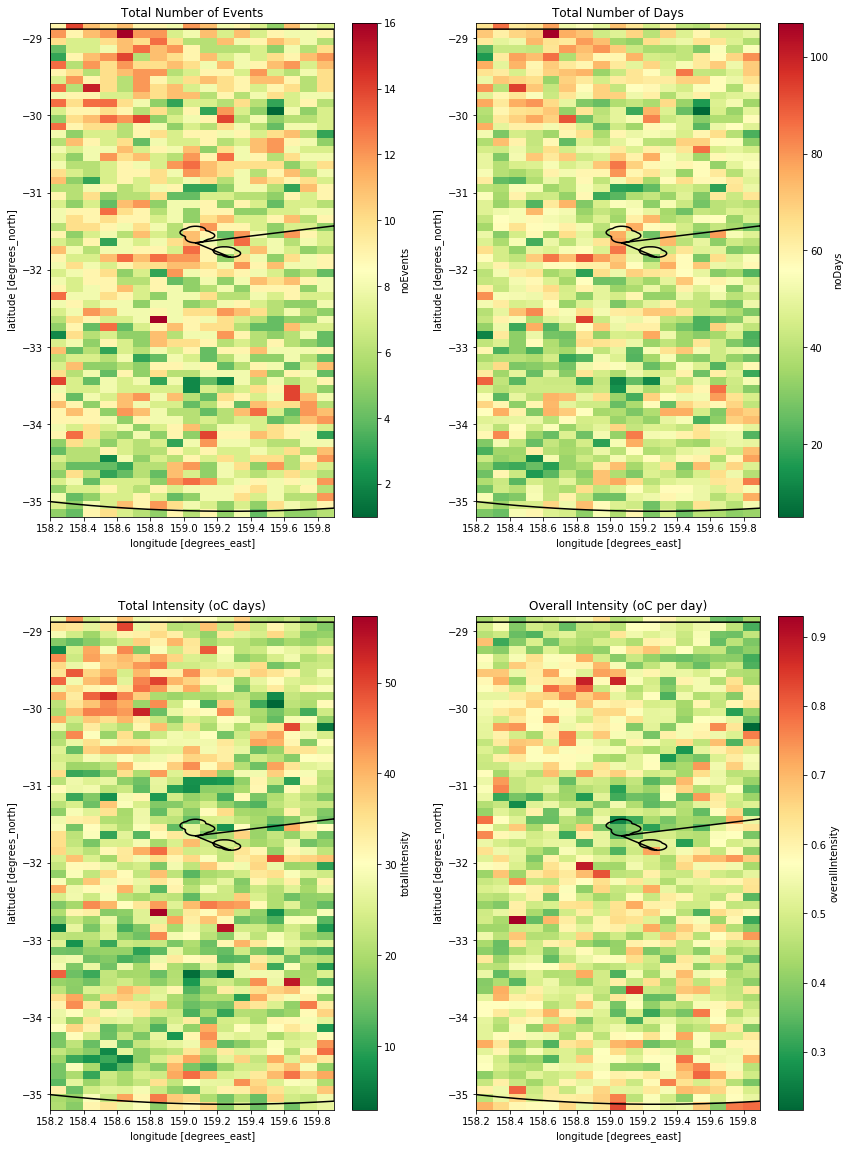

In [60]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.noEvents.plot(cmap='RdYlGn_r')
plt.title('Total Number of Events')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.noDays.plot(cmap='RdYlGn_r')
plt.title('Total Number of Days')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.totalIntensity.plot(cmap='RdYlGn_r')
plt.title('Total Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.overallIntensity.plot(cmap='RdYlGn_r')
plt.title('Overall Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()

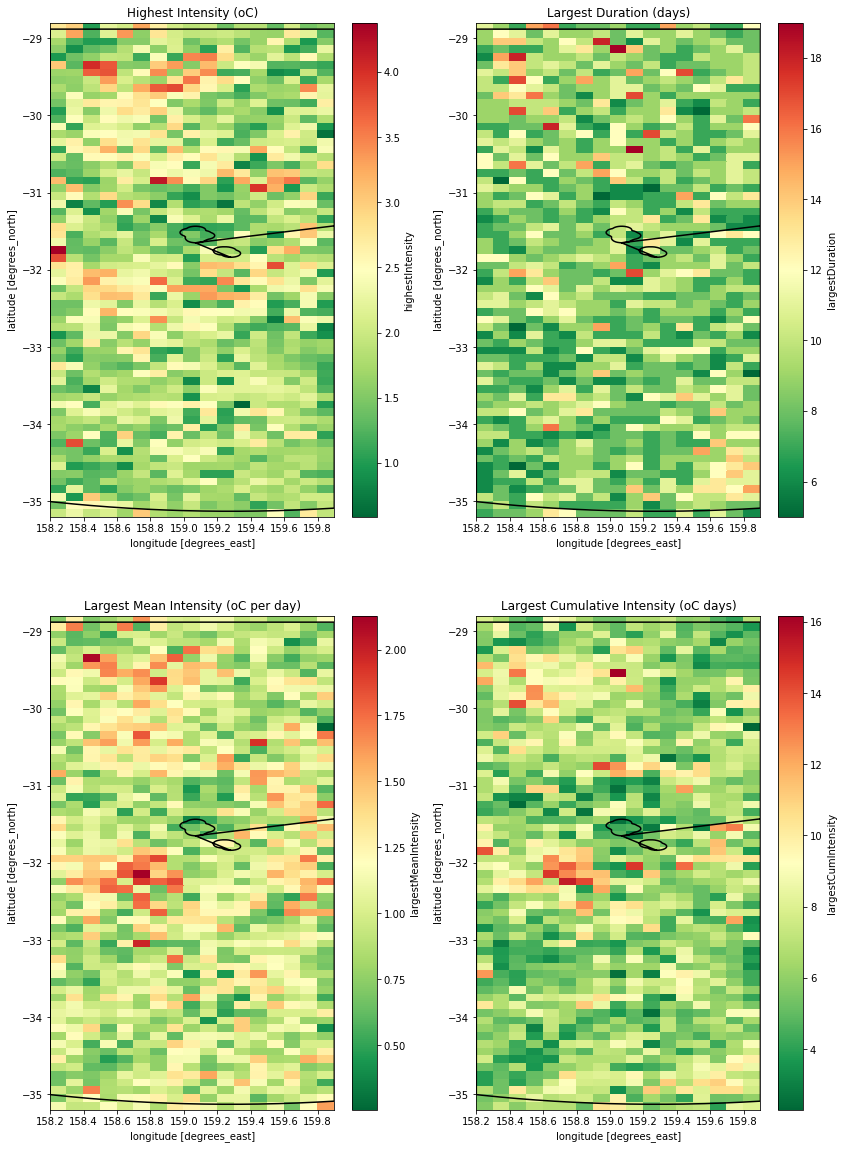

In [61]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.highestIntensity.plot(cmap='RdYlGn_r')
plt.title('Highest Intensity (oC)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.largestDuration.plot(cmap='RdYlGn_r')
plt.title('Largest Duration (days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.largestMeanIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Mean Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.largestCumIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Cumulative Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()
